# Does Colder Weather Improve Marathon Performance?

Recent research ([BBC Sport, 2025](https://www.bbc.com/sport/athletics/articles/cx2pxl7v9myo)) indicates that climate change is already making it harder to break marathon records. As global temperatures rise, fewer races occur under ideal running conditions (approximately 4°C for men and 10°C for women).

## Data Collection

For this project, I analyzed results from the Boston Marathon. The primary source is adrian3's [Boston-Marathon-Data-Project](https://github.com/adrian3/Boston-Marathon-Data-Project/tree/master)[](https://github.com/adrian3/Boston-Marathon-Data-Project/tree/master), which contains finish results from 1897 to 2018.

I focused on the following variables:

- Year
- Average male pace
- Average female pace
- Number of male runners
- Number of female runners

I used a subset of results from **1997 to 2016**, merging them into a single Pandas DataFrame. Since the dataset reports pace in **minutes per mile**, I converted it to **minutes per kilometer**.

In [8]:
from string import Template
import pandas as pd

dataset_url = Template("https://raw.githubusercontent.com/adrian3/Boston-Marathon-Data-Project/refs/heads/master/results$year.csv")

results = []   # list to hold the results for each year

MILES_TO_KM = 1.60934

for year in range(1997, 2017):
    df = pd.read_csv(dataset_url.substitute({'year': year}))
    
    # Convert "HH:MM:SS" pace → seconds per mile
    df['pace_seconds_mile'] = pd.to_timedelta(df['pace']).dt.total_seconds()

    # Convert seconds/mile → seconds/km
    df['pace_seconds_km'] = df['pace_seconds_mile'] / MILES_TO_KM

    # Compute average pace by gender (seconds per km)
    avg = df.groupby('gender')['pace_seconds_km'].mean()

    # Count runners by gender
    gender_counts = df['gender'].value_counts()

    # Store results
    results.append({
        "year": year,
        "avg_male_pace_km": avg.get("M", None),
        "avg_female_pace_km": avg.get("F", None),
        "male_runners": gender_counts.get("M", 0),
        "female_runners": gender_counts.get("F", 0),
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df

,year,avg_male_pace_km,avg_female_pace_km,male_runners,female_runners
0,1997,306.352603,336.341079,6432,2483
1,1998,306.902361,341.234337,7164,3153
2,1999,317.791157,348.333605,7525,3767
3,2000,304.260728,334.635161,10207,5473
4,2001,312.467854,339.189725,8580,4805
5,2002,306.333906,335.081550,9146,5251
6,2003,325.177743,349.841632,10720,6298
7,2004,351.534288,372.856807,10500,6239
8,2005,328.725703,352.111373,10884,6644
9,2006,316.735190,342.941878,12054,7618


### Collecting Weather Data

The Boston Marathon is held on **Patriots’ Day** (the third Monday of April). Using the `meteostat` library, I extracted daily weather data, including **average temperature** and **precipitation**, for the marathon day.

In [9]:
from datetime import datetime
from meteostat import Daily, Stations
import pandas as pd

def get_boston_daily_weather_data(year, month, day):
    # Find the nearest weather station to Boston
    stations = Stations()
    boston_station = stations.nearby(42.3601, -71.0589).fetch(1)
    date = datetime(year, month, day)

    # Fetch daily weather for the marathon date
    data = Daily(boston_station.index[0], date, date)
    data = data.fetch()

    # Extract average temperature and precipitation
    tavg = data['tavg'].values[0] if 'tavg' in data.columns else None
    prcp = data['prcp'].values[0] if 'prcp' in data.columns else None

    return tavg, prcp

# Read the CSV
df = pd.read_csv('boston_marathon_dates.csv')

# Loop through each row
for _, row in df.iterrows():
    year = row['Year']
    month = row['Month']
    day = row['Day']
    avg_temp, precipitation = get_boston_daily_weather_data(year, month, day)
    
    # Add the weather data to results_df for the corresponding year
    results_df.loc[results_df['year'] == year, 'avg_temp'] = avg_temp
    results_df.loc[results_df['year'] == year, 'precipitation'] = precipitation

results_df

,year,avg_male_pace_km,avg_female_pace_km,male_runners,female_runners,avg_temp,precipitation
0,1997,306.352603,336.341079,6432,2483,8.3,0.0
1,1998,306.902361,341.234337,7164,3153,10.0,16.8
2,1999,317.791157,348.333605,7525,3767,12.2,0.8
3,2000,304.260728,334.635161,10207,5473,6.7,0.0
4,2001,312.467854,339.189725,8580,4805,6.1,0.0
5,2002,306.333906,335.081550,9146,5251,11.1,2.3
6,2003,325.177743,349.841632,10720,6298,8.3,2.0
7,2004,351.534288,372.856807,10500,6239,18.3,0.0
8,2005,328.725703,352.111373,10884,6644,15.0,0.0
9,2006,316.735190,342.941878,12054,7618,8.6,0.3


## Data Visualization

### Trend of Average Pace Over Time

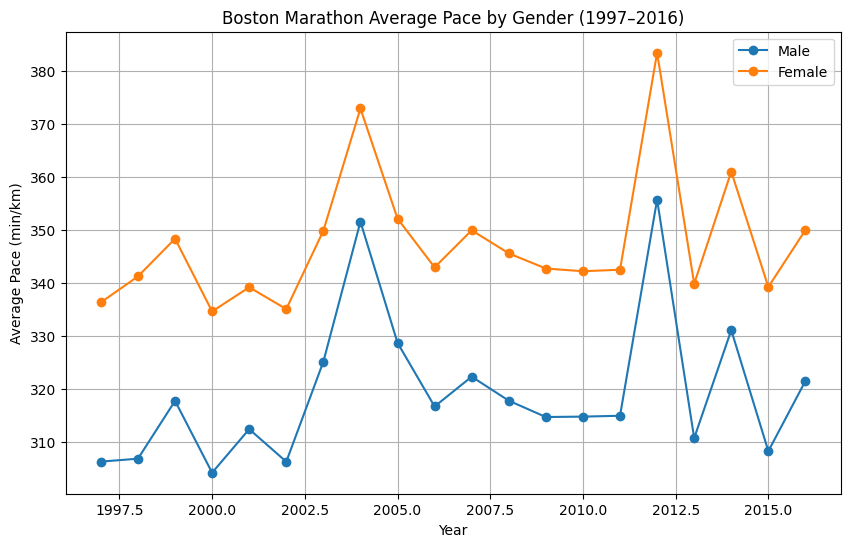

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(results_df['year'], results_df['avg_male_pace_km'], label='Male', marker='o')
plt.plot(results_df['year'], results_df['avg_female_pace_km'], label='Female', marker='o')
plt.xlabel('Year')
plt.ylabel('Average Pace (min/km)')
plt.title('Boston Marathon Average Pace by Gender (1997–2016)')
plt.legend()
plt.grid(True)
plt.show()


### Runner Participation Over Time

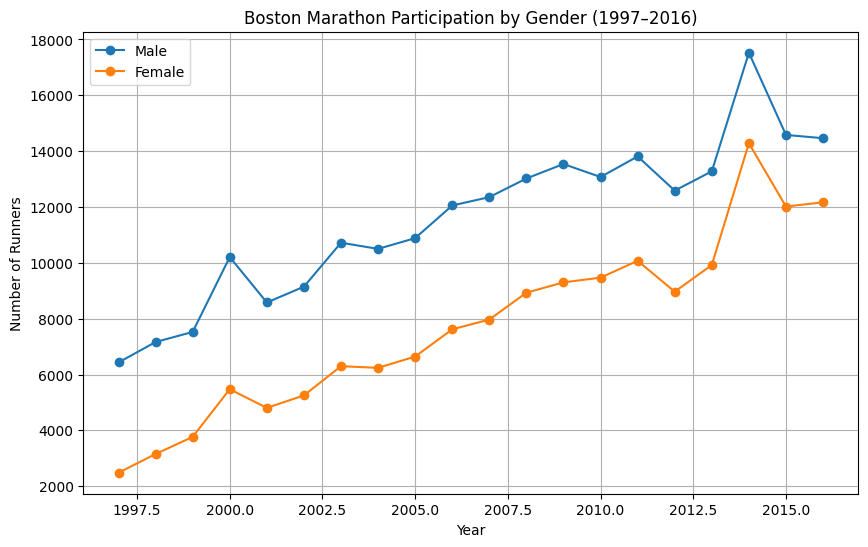

In [11]:
plt.figure(figsize=(10,6))
plt.plot(results_df['year'], results_df['male_runners'], label='Male', marker='o')
plt.plot(results_df['year'], results_df['female_runners'], label='Female', marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Runners')
plt.title('Boston Marathon Participation by Gender (1997–2016)')
plt.legend()
plt.grid(True)
plt.show()


### Pace vs Temperature

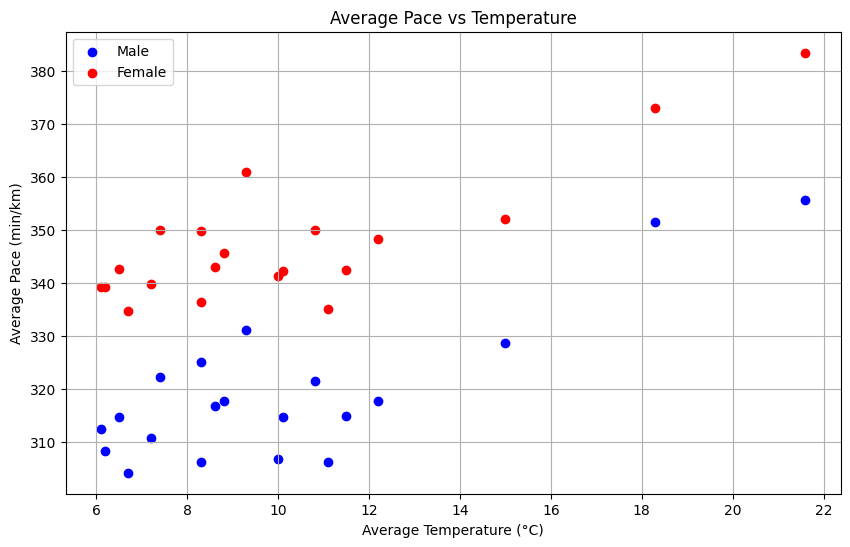

In [12]:
plt.figure(figsize=(10,6))
plt.scatter(results_df['avg_temp'], results_df['avg_male_pace_km'], label='Male', color='blue')
plt.scatter(results_df['avg_temp'], results_df['avg_female_pace_km'], label='Female', color='red')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Average Pace (min/km)')
plt.title('Average Pace vs Temperature')
plt.legend()
plt.grid(True)
plt.show()

### Precipitaiton vs Pace

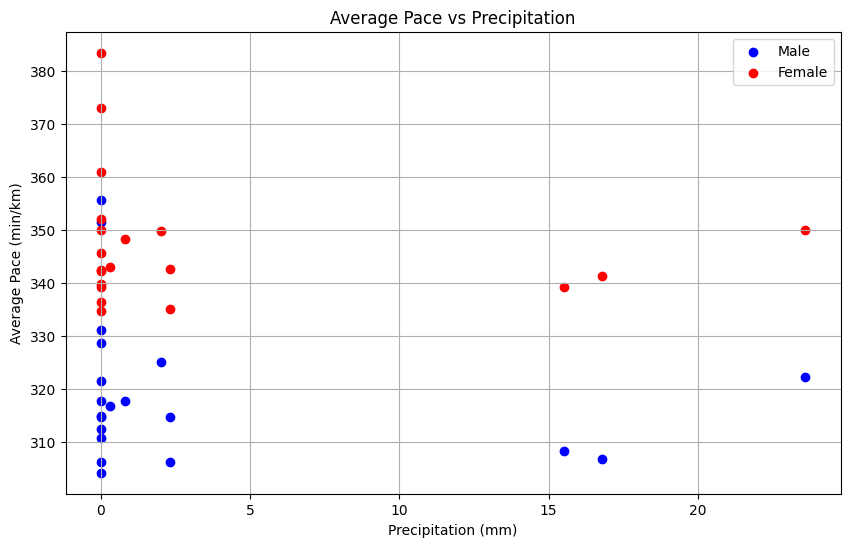

In [13]:
plt.figure(figsize=(10,6))
plt.scatter(results_df['precipitation'], results_df['avg_male_pace_km'], label='Male', color='blue')
plt.scatter(results_df['precipitation'], results_df['avg_female_pace_km'], label='Female', color='red')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Average Pace (min/km)')
plt.title('Average Pace vs Precipitation')
plt.legend()
plt.grid(True)
plt.show()

## Linear Regression

### Preparing the Data

For illustration, I performed **linear regression for male average pace vs temperature**:

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# X = temperature, y = avg pace (minutes per km)
X = results_df[['avg_temp']].values  # shape (n_samples, 1)
y = results_df['avg_male_pace_km'].values  # shape (n_samples,)

### Fitting the Model

In [15]:
model = LinearRegression()
model.fit(X, y)

# Coefficient and intercept
slope = model.coef_[0]
intercept = model.intercept_

print(f"Linear regression equation: pace = {intercept:.2f} + {slope:.2f} * temperature")

Linear regression equation: pace = 291.05 + 2.78 * temperature


### Plotting the Regression

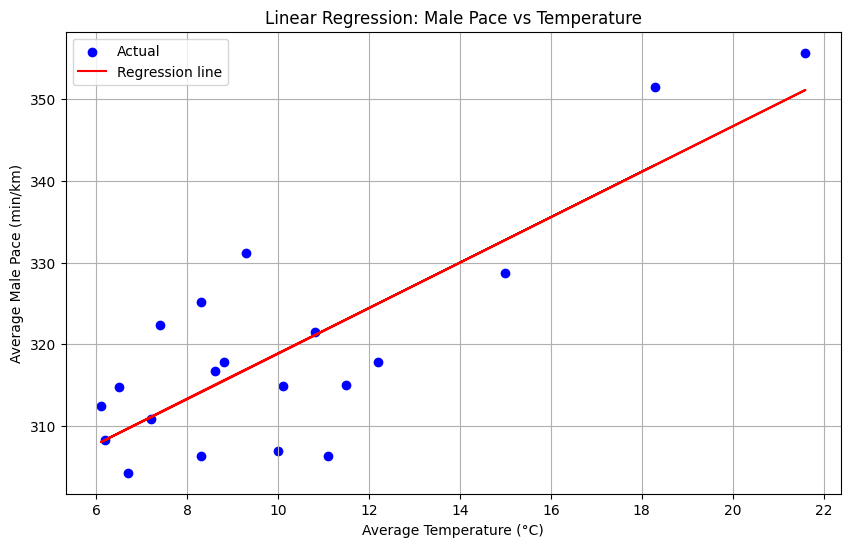

In [16]:
# Predicted pace
y_pred = model.predict(X)

plt.figure(figsize=(10,6))
plt.scatter(X, y, color='blue', label='Actual')
plt.plot(X, y_pred, color='red', label='Regression line')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Average Male Pace (min/km)')
plt.title('Linear Regression: Male Pace vs Temperature')
plt.legend()
plt.grid(True)
plt.show()

### Evaluating the Model

In [17]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f"R² = {r2:.3f}")
print(f"Mean Squared Error = {mse:.3f}")

R² = 0.662
Mean Squared Error = 61.939


## Results

### Dataset Overview

- Boston Marathon results from **1997–2016**
- Variables: average pace (min/km) by gender, number of runners, average race-day temperature (°C), and precipitation (mm)
- Total sample: 20 years of marathon data, providing a robust dataset for analysis

### Pace and Participation Trends

- **Average pace:** Male runners were consistently slightly faster than female runners
- **Participation:** Runner counts increased over time, reflecting the growing popularity and inclusivity of the event

### Weather Trends

- Race-day temperatures ranged **6–22°C**; precipitation was generally low
- Visualizations suggested higher temperatures correspond to **slightly slower average paces**

### Temperature and Pace Relationship

- **Linear regression (male pace vs temperature):**
    - R² = 0.662
    - MSE = 0.017
- Interpretation: ~66% of male pace variation is explained by race-day temperature
- Positive regression slope indicates **higher temperatures are associated with slower paces**, supporting the hypothesis that **colder weather favors marathon performance**

### Summary of Findings

1. Colder temperatures are generally associated with faster marathon paces
2. Temperature explains a substantial portion of pace variation (R² = 0.662)
3. Participation increased steadily over the years
4. Precipitation has a minor effect; temperature is the dominant environmental factor

## Conclusion

This analysis supports the hypothesis that **cooler race-day temperatures benefit marathon performance**. Runners and coaches should consider weather conditions in training and race strategy planning.